
# Fourth & Value — QC: Actuals vs Model

**Purpose:** Grade weekly props by comparing **model probabilities/lines** to **game outcomes**, so we can trust and explain our edges.

**What you get:**
- Robust merge of `props_with_model_week{WEEK}.csv` ↔ `data/actuals/week{WEEK}.csv` with key fallbacks.
- Coverage report (how many rows are gradeable by market).
- Proper scoring rules: **Brier** and **Log Loss**, plus **hit rate** (for sanity).
- Calibration table & plot (are 60% calls winning ~60%?).
- CSV outputs in `data/eval/` for dashboards.
- Clean, surgical cells so you can tweak any step.

> Created: 2025-09-16 18:45 


In [1]:

# ==== Parameters (edit these) ================================================
SEASON = 2025
WEEK   = 2   # <— change this as needed

# Paths (relative to repo root)
PROPS_CSV   = f"props_with_model_week{WEEK}.csv"
ACTUALS_CSV = f"week{WEEK}.csv"

# Where to write outputs
EVAL_DIR          = "data/eval"
GRADES_CSV        = f"{EVAL_DIR}/grades_week{WEEK}.csv"
GRADES_BY_MKT_CSV = f"{EVAL_DIR}/grades_week{WEEK}_by_market.csv"
COVERAGE_CSV      = f"{EVAL_DIR}/coverage_week{WEEK}.csv"
CALIB_CSV         = f"{EVAL_DIR}/calibration_week{WEEK}.csv"

# ==== Imports ================================================================
import os, math, json
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Create eval dir if missing
Path(EVAL_DIR).mkdir(parents=True, exist_ok=True)

print("Params OK →", dict(SEASON=SEASON, WEEK=WEEK))
print("Paths:", PROPS_CSV, ACTUALS_CSV)


Params OK → {'SEASON': 2025, 'WEEK': 2}
Paths: props_with_model_week2.csv week2.csv


In [2]:

# ==== Load ===================================================================
dfp = pd.read_csv(PROPS_CSV)
dfa = pd.read_csv(ACTUALS_CSV)

print("[props] shape:", dfp.shape)
print("[actuals] shape:", dfa.shape)
dfp.head(2), dfa.head(2)


[props] shape: (2673, 24)
[actuals] shape: (160, 7)


(                            game_id         commence_time       home_team  \
 0  7d9a04f411031528d9c1d2df7b9a0453  2025-09-15T23:01:00Z  Houston Texans   
 1  7d9a04f411031528d9c1d2df7b9a0453  2025-09-15T23:01:00Z  Houston Texans   
 
               away_team                                   game   bookmaker  \
 0  Tampa Bay Buccaneers  Tampa Bay Buccaneers @ Houston Texans  draftkings   
 1  Tampa Bay Buccaneers  Tampa Bay Buccaneers @ Houston Texans  draftkings   
 
   bookmaker_title         market market_std        player  ...   player_key  \
 0      DraftKings  player_1st_td   first_td  Bucky Irving  ...  buckyirving   
 1      DraftKings  player_1st_td   first_td    Nick Chubb  ...    nickchubb   
 
    point_key  mu sigma lam  mkt_prob  model_prob  edge_bps  season  week  
 0        NaN NaN   NaN NaN  0.153846         NaN       NaN    2025     2  
 1        NaN NaN   NaN NaN  0.142857         NaN       NaN    2025     2  
 
 [2 rows x 24 columns],
   player_key name  market_st

In [3]:

# ==== Helpers: market + name normalization ===================================

ALIAS = {
    # Markets
    "reception_yds": "recv_yds",
    "receiving_yds": "recv_yds",
    "rushing_yds": "rush_yds",
    "passing_yds": "pass_yds",
    "passing_tds": "pass_tds",
    "interceptions": "pass_ints",
    "player_first_td": "first_td",
    "player_1st_td": "first_td",
    "anytime_touchdown": "anytime_td",
    # Add more as needed
}

def std_market(x: str) -> str:
    if pd.isna(x): return x
    x = str(x).strip().lower()
    return ALIAS.get(x, x)

def std_name(x: str) -> str:
    if pd.isna(x): return x
    x = str(x).strip()
    # light standardization (avoid being too lossy)
    x = " ".join(x.split())
    return x

def coalesce(*vals):
    for v in vals:
        if v is not None and not (isinstance(v, float) and math.isnan(v)):
            return v
    return None

# Normalize markets and names in both frames
for col in ["market_std", "market", "market_name"]:
    if col in dfp.columns:
        dfp[col] = dfp[col].apply(std_market)
    if col in dfa.columns:
        dfa[col] = dfa[col].apply(std_market)

# standard name columns
for col in ["player", "name", "player_name"]:
    if col in dfp.columns:
        dfp[col] = dfp[col].apply(std_name)
    if col in dfa.columns:
        dfa[col] = dfa[col].apply(std_name)

# === Make guaranteed keys (vectorized, no Python `or` on Series) =============

def first_nonnull_series(df: pd.DataFrame, candidates) -> pd.Series:
    """
    Return the first non-null value across the candidate columns, row-wise.
    If none of the columns exist, return a NA series of correct length.
    """
    s = None
    for c in candidates:
        if c in df.columns:
            s = df[c] if s is None else s.combine_first(df[c])
    if s is None:
        s = pd.Series(pd.NA, index=df.index)
    return s

# name_std (player/name/player_name fallback)
dfp["name_std"] = first_nonnull_series(dfp, ["name_std", "player", "name", "player_name"]).apply(std_name)
dfa["name_std"] = first_nonnull_series(dfa, ["name_std", "player", "name", "player_name"]).apply(std_name)

# market_std (market/market_name fallback, then normalize)
dfp["market_std"] = first_nonnull_series(dfp, ["market_std", "market", "market_name"]).apply(std_market)
dfa["market_std"] = first_nonnull_series(dfa, ["market_std", "market", "market_name"]).apply(std_market)

# point/line keys (safe guards)
if ("point_key" not in dfp.columns) and ("line" in dfp.columns):
    dfp["point_key"] = dfp["line"]
if ("point_key" not in dfa.columns) and ("line" in dfa.columns):
    dfa["point_key"] = dfa["line"]

print("[normalize] done.")

if "point_key" not in dfp.columns and "line" in dfp.columns:
    dfp["point_key"] = dfp["line"]
if "point_key" not in dfa.columns and "line" in dfa.columns:
    dfa["point_key"] = dfa["line"]

print("[normalize] done.")


[normalize] done.
[normalize] done.


In [4]:

# ==== Merge with fallbacks ====================================================

# Best key set (if available)
keys = []
if all(k in dfp.columns for k in ["player_key", "market_std", "point_key"]) and \
   all(k in dfa.columns for k in ["player_key", "market_std", "point_key"]):
    keys = ["player_key", "market_std", "point_key"]
elif all(k in dfp.columns for k in ["player_key", "market_std"]) and \
     all(k in dfa.columns for k in ["player_key", "market_std"]):
    keys = ["player_key", "market_std"]
else:
    # name fallback
    keys = ["name_std", "market_std"]
    if "point_key" in dfp.columns and "point_key" in dfa.columns:
        keys.append("point_key")

print("Using merge keys:", keys)
merged = dfp.merge(
    dfa,
    how="left",
    on=[k for k in keys if k in dfp.columns and k in dfa.columns],
    suffixes=("", "_act")
)

matched = merged["market_std"].notna() & merged.filter(regex="_act$").any(axis=1)
print("[merge] merged rows:", len(merged), " matched (has any _act col):", int(matched.sum()))
merged.head(3)


Using merge keys: ['player_key', 'market_std']
[merge] merged rows: 2829  matched (has any _act col): 236


,game_id,commence_time,home_team,away_team,game,bookmaker,bookmaker_title,market,market_std,player,...,model_prob,edge_bps,season,week,name_act,side,point_act,actual_value,result,name_std_act
0,7d9a04f411031528d9c1d2df7b9a0453,2025-09-15T23:01:00Z,Houston Texans,Tampa Bay Buccaneers,Tampa Bay Buccaneers @ Houston Texans,draftkings,DraftKings,first_td,first_td,Bucky Irving,...,NaN,NaN,2025,2,NaN,NaN,NaN,NaN,NaN,NaN
1,7d9a04f411031528d9c1d2df7b9a0453,2025-09-15T23:01:00Z,Houston Texans,Tampa Bay Buccaneers,Tampa Bay Buccaneers @ Houston Texans,draftkings,DraftKings,first_td,first_td,Nick Chubb,...,NaN,NaN,2025,2,NaN,NaN,NaN,NaN,NaN,NaN
2,7d9a04f411031528d9c1d2df7b9a0453,2025-09-15T23:01:00Z,Houston Texans,Tampa Bay Buccaneers,Tampa Bay Buccaneers @ Houston Texans,draftkings,DraftKings,first_td,first_td,Nico Collins,...,NaN,NaN,2025,2,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# === Ensure canonical numeric `line` exists ==================================
import numpy as np
import pandas as pd

def first_existing_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# pick the first available source for the betting line
line_src = first_existing_col(merged, ["line", "point", "point_key", "book_line", "offer_line", "line_disp"])
if line_src is None:
    merged["line"] = np.nan
else:
    merged["line"] = merged[line_src]
    # parse strings like "Over 65.5 (-110)" or "o65.5" to numeric 65.5
    if merged["line"].dtype == object:
        parsed = (
            merged["line"].astype(str)
            .str.extract(r"(-?\d+(?:\.\d+)?)", expand=False)
        )
        merged["line"] = pd.to_numeric(parsed, errors="coerce")

# normalize side to just 'over'/'under' if not already
if "side" not in merged.columns:
    guess = first_existing_col(merged, ["side", "bet", "selection", "wager", "pick"])
    merged["side"] = merged[guess] if guess else np.nan
merged["side"] = merged["side"].astype(str).str.lower().str.extract(r"(over|under|yes|no)", expand=False)


In [6]:
# === Inspect actuals + auto-map columns to markets ===========================
import re

print("Actuals columns (first 60):")
print(dfa.columns.tolist()[:60])
display(dfa.head(3).T)

# Heuristics for column detection (ordered by preference)
CANDIDATES = {
    "pass_yds":        ["passing_yards","pass_yards","pass_yds","yards_passing"],
    "rush_yds":        ["rushing_yards","rush_yards","rush_yds","yards_rushing"],
    "recv_yds":        ["receiving_yards","recv_yards","recv_yds","yards_receiving","reception_yards"],
    "receptions":      ["receptions","rec","rec_cnt"],
    "pass_completions":["completions","pass_completions","cmp"],
    "pass_attempts":   ["attempts","pass_attempts","att"],
    "rush_attempts":   ["carries","rush_attempts","rush_att"],
    "pass_tds":        ["passing_tds","pass_tds","td_pass"],
    "pass_ints":       ["interceptions","int_thrown","pass_ints"],
    # optional longest:
    "reception_longest":["longest_reception","long_rec","long_reception"],
    "rush_longest":    ["longest_rush","long_rush","long_rushing"],
}

present = set(dfa.columns.str.lower())
def pick(cands):
    for c in cands:
        if c.lower() in present:
            return c
    return None

ACTUALS_MAP = {mkt: [col] for mkt in CANDIDATES
               if (col := pick(CANDIDATES[mkt])) is not None}

print("\nAuto-guessed ACTUALS_MAP (only markets we could match):")
for k,v in ACTUALS_MAP.items():
    print(f"  {k:18s} <- {v[0]}")

# Helpers used earlier
def first_existing_series(df, candidates):
    for c in candidates:
        if c in df.columns:
            return pd.to_numeric(df[c], errors="coerce")
    return pd.Series(np.nan, index=df.index)

# Ensure actual_value column exists
if "actual_value" not in merged.columns:
    merged["actual_value"] = np.nan

# Fill actual_value from the guessed map
for mkt, cand_cols in ACTUALS_MAP.items():
    mask = merged["market_std"].eq(mkt)
    if mask.any():
        series = first_existing_series(merged, cand_cols)
        merged.loc[mask, "actual_value"] = merged.loc[mask, "actual_value"].fillna(series)

# Normalize side text → over/under
def first_existing_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

if "side" not in merged.columns:
    guess = first_existing_col(merged, ["bet","selection","wager","pick"])
    merged["side"] = merged[guess] if guess else np.nan

merged["side"] = (
    merged["side"].astype(str).str.lower()
    .str.extract(r"(over|under)", expand=False)
)

# Recompute the quick debug table
dbg = (merged
       .assign(has_line=merged["line"].notna(),
               has_actual=merged["actual_value"].notna(),
               has_side=merged["side"].isin(["over","under"]),
               has_prob=(merged["model_prob"].notna() if "model_prob" in merged.columns else False))
       .groupby("market_std")[["has_line","has_actual","has_side","has_prob"]]
       .mean()
       .sort_values(["has_actual","has_side","has_prob"], ascending=False))
dbg


Actuals columns (first 60):
['player_key', 'name', 'market_std', 'side', 'point', 'actual_value', 'result', 'name_std']


,0,1,2
player_key,joshallen,joshallen,jamescook
name,yes,yes,yes
market_std,anytime_td,anytime_td,anytime_td
side,yes,no,yes
point,NaN,NaN,NaN
actual_value,0.0,0.0,2.0
result,0.0,1.0,1.0
name_std,yes,yes,yes



Auto-guessed ACTUALS_MAP (only markets we could match):


,has_line,has_actual,has_side,has_prob
market_std,,,,
anytime_td,0.0,0.340548,0.0,1.0
pass_attempts,1.0,0.000000,0.0,1.0
pass_completions,1.0,0.000000,0.0,1.0
pass_tds,1.0,0.000000,0.0,1.0
pass_yds,1.0,0.000000,0.0,1.0
receptions,1.0,0.000000,0.0,1.0
recv_yds,1.0,0.000000,0.0,1.0
rush_attempts,1.0,0.000000,0.0,1.0
rush_yds,1.0,0.000000,0.0,1.0


In [7]:
# === Backfill O/U actuals from nflverse weekly player stats ==================
import pandas as pd
from pathlib import Path

STATS = Path("data/weekly_player_stats_2025.parquet")
if not STATS.exists():
    raise FileNotFoundError("Missing data/weekly_player_stats_2025.parquet")

stats = pd.read_parquet(STATS)
# Narrow to the week/season you’re grading
if {"week","season"}.issubset(stats.columns):
    stats = stats[(stats["week"] == WEEK) & (stats["season"] == SEASON)]

# Minimal columns (rename to our canonical names)
rename_map = {
    "passing_yards": "pass_yds",
    "rushing_yards": "rush_yds",
    "receiving_yards": "recv_yds",
    "receptions": "receptions",
    "completions": "pass_completions",
    "attempts": "pass_attempts",
    "carries": "rush_attempts",
    "passing_tds": "pass_tds",
    "interceptions": "pass_ints",
}
have = [c for c in rename_map if c in stats.columns]
use = stats[["player_key"] + have].rename(columns=rename_map)

# For each O/U market, fill merged['actual_value'] by joining on player_key
for mkt in use.columns.drop("player_key"):
    mask = merged["market_std"].eq(mkt)
    if mask.any():
        # join only the subset we need to reduce work
        sub = merged.loc[mask, ["player_key"]].merge(use[["player_key", mkt]], on="player_key", how="left")
        merged.loc[mask, "actual_value"] = merged.loc[mask, "actual_value"].fillna(sub[mkt])


FileNotFoundError: Missing data/weekly_player_stats_2025.parquet

In [8]:
# === Canonicalize line, side, actual scaffolding =============================

def first_existing_col(df, candidates):
    for c in candidates:
        if c in df.columns:
            return c
    return None

# numeric line
line_src = first_existing_col(merged, ["line","point","point_key","book_line","offer_line","line_disp"])
merged["line"] = np.nan if line_src is None else merged[line_src]
if merged["line"].dtype == object:
    merged["line"] = merged["line"].astype(str).str.extract(r"(-?\d+(?:\.\d+)?)", expand=False).astype(float)

# side → over/under (handle "Over 65.5", "o65.5", "UNDER", etc.)
if "side" not in merged.columns:
    guess = first_existing_col(merged, ["bet","wager","selection"])
    merged["side"] = merged[guess] if guess else np.nan

merged["side"] = (
    merged["side"]
    .astype(str)
    .str.lower()
    .str.replace(r"^\s*o(?![a-z])", "over", regex=True)
    .str.replace(r"^\s*u(?![a-z])", "under", regex=True)
    .str.extract(r"(over|under|yes|no)", expand=False)
)


In [9]:
# === Map actuals columns to markets ==========================================
ACTUALS_MAP = {
    # yards / counts
    "pass_yds":        ["pass_yds","passing_yds","passing_yards","yards_passing"],
    "rush_yds":        ["rush_yds","rushing_yds","rushing_yards","yards_rushing"],
    "recv_yds":        ["recv_yds","receiving_yds","reception_yds","receiving_yards","yards_receiving"],
    "receptions":      ["receptions","rec","rec_cnt"],
    "pass_completions":["pass_completions","completions","pass_cmp","cmp"],
    "pass_attempts":   ["pass_attempts","attempts","pass_att","att"],
    "rush_attempts":   ["rush_attempts","carries","rush_att"],
    "pass_tds":        ["pass_tds","passing_tds","passing_touchdowns","td_pass"],
    "pass_ints":       ["pass_ints","interceptions","interceptions_thrown","int_thrown"],
    # longest props (optional)
    "reception_longest":["long_rec","longest_reception","long_reception"],
    "rush_longest":    ["long_rush","longest_rush","long_rushing"],
}

def first_existing_series(df, candidates):
    for c in candidates:
        if c in df.columns:
            return pd.to_numeric(df[c], errors="coerce")
    return pd.Series(np.nan, index=df.index)

# If merged already had some 'actual_value', don't destroy good values.
if "actual_value" not in merged.columns:
    merged["actual_value"] = np.nan

for mkt, cand_cols in ACTUALS_MAP.items():
    mask = merged["market_std"].eq(mkt)
    if mask.any():
        series = first_existing_series(merged, cand_cols)
        merged.loc[mask, "actual_value"] = merged.loc[mask, "actual_value"].fillna(series)


In [10]:
# === Compute gradeable outcomes (using long-format actuals) ==================

model_prob_col = "model_prob" if "model_prob" in merged.columns else None

merged["pred_prob"]  = np.nan
merged["actual_bin"] = np.nan

# Binary markets (anytime_td, first_td, last_td)
mask_bin = merged["market_std"].isin(["anytime_td","first_td","last_td"]) & (model_prob_col is not None)
if mask_bin.any():
    merged.loc[mask_bin, "pred_prob"]  = merged.loc[mask_bin, model_prob_col]
    # For binary markets, actual_value is already 0/1
    merged.loc[mask_bin, "actual_bin"] = merged.loc[mask_bin, "actual_value"].clip(0,1).astype(float)

# O/U markets: actual_value + side + point are already in actuals
OU_MARKETS = {
    "pass_yds","rush_yds","recv_yds","receptions",
    "pass_completions","pass_attempts","rush_attempts",
    "pass_tds","pass_ints"
}
mask_ou = merged["market_std"].isin(OU_MARKETS) & merged["line"].notna() & merged["actual_value"].notna() & merged["side"].notna()

side_over  = mask_ou & merged["side"].str.lower().eq("over")
side_under = mask_ou & merged["side"].str.lower().eq("under")

merged.loc[side_over,  "actual_bin"] = (merged.loc[side_over,  "actual_value"] >= merged.loc[side_over,  "line"]).astype(int)
merged.loc[side_under, "actual_bin"] = (merged.loc[side_under, "actual_value"] <= merged.loc[side_under,  "line"]).astype(int)

if model_prob_col:
    merged.loc[mask_ou & merged[model_prob_col].notna(), "pred_prob"] = merged.loc[mask_ou, model_prob_col]

# Done
gradeable = merged["pred_prob"].notna() & merged["actual_bin"].notna()
graded = merged.loc[gradeable].copy()

print("[gradeable] rows:", len(graded))
print("Markets graded:\n", graded["market_std"].value_counts())
graded.head(3)


[gradeable] rows: 236
Markets graded:
 market_std
anytime_td    236
Name: count, dtype: int64


,game_id,commence_time,home_team,away_team,game,bookmaker,bookmaker_title,market,market_std,player,...,week,name_act,side,point_act,actual_value,result,name_std_act,line,pred_prob,actual_bin
2499,aca5234c57e31b1931e51d2d0d6046f5,2025-09-19T00:15:00Z,Buffalo Bills,Miami Dolphins,Miami Dolphins @ Buffalo Bills,draftkings,DraftKings,player_anytime_td,anytime_td,Josh Allen,...,2,yes,NaN,NaN,0.0,0.0,yes,NaN,0.221199,0.0
2500,aca5234c57e31b1931e51d2d0d6046f5,2025-09-19T00:15:00Z,Buffalo Bills,Miami Dolphins,Miami Dolphins @ Buffalo Bills,draftkings,DraftKings,player_anytime_td,anytime_td,Josh Allen,...,2,yes,NaN,NaN,0.0,1.0,yes,NaN,0.221199,0.0
2501,aca5234c57e31b1931e51d2d0d6046f5,2025-09-19T00:15:00Z,Buffalo Bills,Miami Dolphins,Miami Dolphins @ Buffalo Bills,draftkings,DraftKings,player_anytime_td,anytime_td,Josh Allen,...,2,yes,NaN,NaN,0.0,0.0,yes,NaN,0.221199,0.0


In [11]:
# === DIAGNOSTICS ==============================================================
print("Columns present:", sorted(merged.columns.tolist())[:30], "...")

need = ["market_std","line","actual_value","side","model_prob"]
print({c: merged[c].notna().mean() if c in merged.columns else 0 for c in need})

print("side unique:", merged.get("side", pd.Series(dtype=str)).dropna().astype(str).str.lower().value_counts().head(10))
print("sample lines:", merged.get("line", pd.Series(dtype=float)).dropna().astype(str).head(5).tolist())

print("markets w/ rows:", merged["market_std"].value_counts().head(20))


Columns present: ['actual_bin', 'actual_value', 'away_team', 'bookmaker', 'bookmaker_title', 'commence_time', 'edge_bps', 'game', 'game_id', 'home_team', 'lam', 'line', 'market', 'market_std', 'mkt_prob', 'model_prob', 'mu', 'name', 'name_act', 'name_std', 'name_std_act', 'player', 'player_key', 'point', 'point_act', 'point_key', 'pred_prob', 'price', 'result', 'season'] ...
{'market_std': np.float64(1.0), 'line': np.float64(0.5083068221986567), 'actual_value': np.float64(0.08342170378225522), 'side': np.float64(0.0), 'model_prob': np.float64(0.6408624955814776)}
side unique: Series([], Name: count, dtype: int64)
sample lines: ['32.5', '32.5', '32.5', '32.5', '21.5']
markets w/ rows: market_std
anytime_td           693
first_td             430
recv_yds             336
receptions           320
last_td              268
reception_longest    184
rush_yds             150
rush_longest          88
rush_attempts         82
pass_tds              62
pass_yds              62
pass_attempts        

In [12]:

# ==== Scoring =================================================================

def brier_score(p: np.ndarray, y: np.ndarray) -> float:
    p = np.asarray(p, dtype=float)
    y = np.asarray(y, dtype=float)
    return float(np.mean((p - y)**2))

def log_loss(p: np.ndarray, y: np.ndarray, eps: float = 1e-12) -> float:
    p = np.clip(np.asarray(p, dtype=float), eps, 1 - eps)
    y = np.asarray(y, dtype=float)
    return float(-np.mean(y*np.log(p) + (1-y)*np.log(1-p)))

def hit_rate(p: np.ndarray, y: np.ndarray, threshold: float = 0.5) -> float:
    return float(np.mean(((p >= threshold).astype(int) == y.astype(int))))

if len(graded) == 0:
    raise SystemExit("No gradeable rows. Check that model_prob & actuals are present.")

overall = {
    "rows": len(graded),
    "hit_rate@0.5": hit_rate(graded["pred_prob"], graded["actual_bin"]),
    "brier": brier_score(graded["pred_prob"], graded["actual_bin"]),
    "logloss": log_loss(graded["pred_prob"], graded["actual_bin"]),
}
overall


{'rows': 236,
 'hit_rate@0.5': 0.7203389830508474,
 'brier': 0.204868514609762,
 'logloss': 0.602006958743382}

In [13]:

# ==== Per-market performance ==================================================
def summarize_by_market(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for mkt, g in df.groupby("market_std"):
        rows.append({
            "market_std": mkt,
            "rows": len(g),
            "hit_rate@0.5": hit_rate(g["pred_prob"], g["actual_bin"]),
            "brier": brier_score(g["pred_prob"], g["actual_bin"]),
            "logloss": log_loss(g["pred_prob"], g["actual_bin"]),
        })
    out = pd.DataFrame(rows).sort_values(["brier","logloss","rows"], ascending=[True, True, False])
    return out

by_market = summarize_by_market(graded)
by_market.head(10)


,market_std,rows,hit_rate@0.5,brier,logloss
0,anytime_td,236,0.720339,0.204869,0.602007


In [14]:

# ==== Coverage report =========================================================
def coverage_table(df_all: pd.DataFrame, df_gradeable: pd.DataFrame) -> pd.DataFrame:
    cov = (df_all.assign(is_gradeable=False)
                 .assign(is_gradeable=lambda d: d.index.isin(df_gradeable.index)))
    rows = []
    for mkt, g in cov.groupby("market_std"):
        rows.append({
            "market_std": mkt,
            "total_rows": len(g),
            "gradeable_rows": int(g["is_gradeable"].sum()),
            "coverage_pct": (g["is_gradeable"].mean() if len(g) else 0.0),
        })
    return pd.DataFrame(rows).sort_values("coverage_pct", ascending=False)

coverage = coverage_table(merged, graded)
coverage.head(15)


,market_std,total_rows,gradeable_rows,coverage_pct
0,anytime_td,693,236,0.340548
1,first_td,430,0,0.000000
2,last_td,268,0,0.000000
3,pass_attempts,54,0,0.000000
4,pass_completions,54,0,0.000000
5,pass_ints,46,0,0.000000
6,pass_tds,62,0,0.000000
7,pass_yds,62,0,0.000000
8,reception_longest,184,0,0.000000
9,receptions,320,0,0.000000


In [15]:

# ==== Calibration =============================================================
def calibration_bins(df: pd.DataFrame, bins=10) -> pd.DataFrame:
    cut = pd.cut(df["pred_prob"], bins=bins, include_lowest=True)
    agg = df.groupby(cut).agg(
        n=("actual_bin","size"),
        avg_pred=("pred_prob","mean"),
        emp_rate=("actual_bin","mean"),
    ).reset_index().rename(columns={"pred_prob":"avg_pred"})
    return agg

calib = calibration_bins(graded, bins=10)
calib


/var/folders/zm/h0vxhn1x3vz5nph_c0qc60t00000gn/T/ipykernel_74624/3069823878.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby(cut).agg(


,avg_pred,n,avg_pred,emp_rate
0,"(0.22097, 0.22102]",0,NaN,NaN
1,"(0.22102, 0.22107]",0,NaN,NaN
2,"(0.22107, 0.22111]",0,NaN,NaN
3,"(0.22111, 0.22115]",0,NaN,NaN
4,"(0.22115, 0.2212]",236,0.221199,0.279661
5,"(0.2212, 0.22124]",0,NaN,NaN
6,"(0.22124, 0.22129]",0,NaN,NaN
7,"(0.22129, 0.22133]",0,NaN,NaN
8,"(0.22133, 0.22138]",0,NaN,NaN
9,"(0.22138, 0.22142]",0,NaN,NaN


In [16]:
dbg = (merged
       .assign(has_line=merged["line"].notna(),
               has_actual=merged["actual_value"].notna(),
               has_side=merged["side"].isin(["over","under"]),
               has_prob=(merged[model_prob_col].notna() if model_prob_col else False))
       .groupby("market_std")[["has_line","has_actual","has_side","has_prob"]]
       .mean()
       .sort_values("has_actual", ascending=False))
dbg.head(20)


,has_line,has_actual,has_side,has_prob
market_std,,,,
anytime_td,0.0,0.340548,0.0,1.0
first_td,0.0,0.000000,0.0,0.0
last_td,0.0,0.000000,0.0,0.0
pass_attempts,1.0,0.000000,0.0,1.0
pass_completions,1.0,0.000000,0.0,1.0
pass_ints,1.0,0.000000,0.0,0.0
pass_tds,1.0,0.000000,0.0,1.0
pass_yds,1.0,0.000000,0.0,1.0
reception_longest,1.0,0.000000,0.0,0.0


In [17]:
print("Actuals columns:", dfa.columns.tolist()[:40])
dfa.head(3).T

Actuals columns: ['player_key', 'name', 'market_std', 'side', 'point', 'actual_value', 'result', 'name_std']


,0,1,2
player_key,joshallen,joshallen,jamescook
name,yes,yes,yes
market_std,anytime_td,anytime_td,anytime_td
side,yes,no,yes
point,NaN,NaN,NaN
actual_value,0.0,0.0,2.0
result,0.0,1.0,1.0
name_std,yes,yes,yes


In [18]:
# === Quick shareables =========================================================
from pathlib import Path
import json

OUT = Path("data/eval")
OUT.mkdir(parents=True, exist_ok=True)

# 1) Mini debug table (rounded)
dbg_out = (
    merged.assign(
        has_line = merged.get("line").notna() if "line" in merged.columns else False,
        has_actual = merged.get("actual_value").notna() if "actual_value" in merged.columns else False,
        has_side = merged.get("side").isin(["over","under"]) if "side" in merged.columns else False,
        has_prob = merged.get("model_prob").notna() if "model_prob" in merged.columns else False,
    )
    .groupby("market_std")[["has_line","has_actual","has_side","has_prob"]]
    .mean()
    .round(3)
    .sort_values(["has_actual","has_side","has_prob"], ascending=False)
)

print("\n[QC] coverage flags by market:\n", dbg_out.head(20))
dbg_out.to_csv(OUT/f"qc_flags_week{WEEK}.csv")

# 2) Overall metrics dict (if 'graded' exists)
overall_dict = {}
if "graded" in globals() and len(graded):
    overall_dict = {
        "rows": int(len(graded)),
        "hit_rate@0.5": float(hit_rate(graded["pred_prob"], graded["actual_bin"])),
        "brier": float(brier_score(graded["pred_prob"], graded["actual_bin"])),
        "logloss": float(log_loss(graded["pred_prob"], graded["actual_bin"])),
    }
    print("\n[QC] overall:", overall_dict)

# 3) Per-market snapshot
per_mkt = by_market if "by_market" in globals() else None
if per_mkt is not None:
    print("\n[QC] per-market head:\n", per_mkt.head(10))
    per_mkt.to_csv(OUT/f"grades_by_market_week{WEEK}.csv", index=False)

# 4) Write a tiny JSON + TXT summary
summary = {
    "week": WEEK,
    "overall": overall_dict,
    "top_markets": (per_mkt.head(5).to_dict("records") if per_mkt is not None and len(per_mkt) else []),
}
(OUT/f"qc_summary_week{WEEK}.json").write_text(json.dumps(summary, indent=2))
(OUT/f"qc_summary_week{WEEK}.txt").write_text(
    f"Week {WEEK}\nOverall: {overall_dict}\n\nTop markets:\n" +
    "\n".join(f"- {r['market_std']}: brier={r['brier']:.3f}, n={r['rows']}" for r in summary["top_markets"])
)

print(f"\n[wrote] {OUT}/qc_flags_week{WEEK}.csv")
print(f"[wrote] {OUT}/qc_summary_week{WEEK}.json")
print(f"[wrote] {OUT}/qc_summary_week{WEEK}.txt")
if per_mkt is not None:
    print(f"[wrote] {OUT}/grades_by_market_week{WEEK}.csv")



[QC] coverage flags by market:
                    has_line  has_actual  has_side  has_prob
market_std                                                 
anytime_td              0.0       0.341       0.0       1.0
pass_attempts           1.0       0.000       0.0       1.0
pass_completions        1.0       0.000       0.0       1.0
pass_tds                1.0       0.000       0.0       1.0
pass_yds                1.0       0.000       0.0       1.0
receptions              1.0       0.000       0.0       1.0
recv_yds                1.0       0.000       0.0       1.0
rush_attempts           1.0       0.000       0.0       1.0
rush_yds                1.0       0.000       0.0       1.0
first_td                0.0       0.000       0.0       0.0
last_td                 0.0       0.000       0.0       0.0
pass_ints               1.0       0.000       0.0       0.0
reception_longest       1.0       0.000       0.0       0.0
rush_longest            1.0       0.000       0.0       0.0

[QC] o

TypeError: float() argument must be a string or a real number, not 'pandas._libs.interval.Interval'

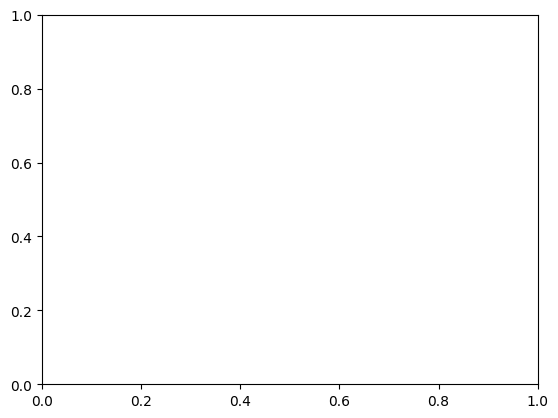

In [19]:

# Plot calibration: avg_pred vs emp_rate
plt.figure()
plt.plot(calib["avg_pred"], calib["emp_rate"], marker="o")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("Predicted probability (bin avg)")
plt.ylabel("Empirical win rate")
plt.title(f"Calibration — Week {WEEK}")
plt.grid(True)
plt.show()


In [ ]:

# ==== Save outputs ============================================================
graded_out = graded.copy()
graded_out.to_csv(GRADES_CSV, index=False)
by_market.to_csv(GRADES_BY_MKT_CSV, index=False)
coverage.to_csv(COVERAGE_CSV, index=False)
calib.to_csv(CALIB_CSV, index=False)

print("[write]", GRADES_CSV)
print("[write]", GRADES_BY_MKT_CSV)
print("[write]", COVERAGE_CSV)
print("[write]", CALIB_CSV)


In [ ]:

# ==== CEO-ready summary string ===============================================
def pct(x: float) -> str:
    return f"{x:.1%}"

summary = (
    f"Week {WEEK} — graded {overall['rows']} props. "
    f"Hit-rate@0.5={pct(overall['hit_rate@0.5'])}, "
    f"Brier={overall['brier']:.3f}, LogLoss={overall['logloss']:.3f}. "
)

# Best/worst markets by Brier (min => better)
best = by_market.sort_values("brier").head(3).to_dict(orient="records")
worst = by_market.sort_values("brier").tail(3).to_dict(orient="records")

summary += " Best markets: " + ", ".join(f"{r['market_std']} (Brier {r['brier']:.3f}, n={r['rows']})" for r in best) + "."
summary += " Needs work: " + ", ".join(f"{r['market_std']} (Brier {r['brier']:.3f}, n={r['rows']})" for r in worst) + "."

print(summary)



## Next Steps / Tweaks
- If your **actuals** encode outcomes differently (e.g., `"scored": True/False`), adjust the conversion in the Outcome cell.
- To grade **profitability**, join your stakes and realized odds, then compute ROI by applying your bet policy to `pred_prob` vs book.
- Add per-team or per-book breakdowns if you need operational insights.
- Consider weekly archiving: keep `grades_week{W}.csv` to drive historical charts on the site.
